<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li><li><span><a href="#END" data-toc-modified-id="END-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>END</a></span></li></ul></div>

In this notebook, we implement the baseline: Low-Rank Tensor Functional Representation model for 3D traffic data imputation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim 
import torch.nn.functional as F
import torch
dtype = torch.cuda.FloatTensor
import math
from typing import Optional,List
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_wmape(var, var_hat):
    return np.sum(np.abs(var - var_hat)) / np.sum(var)

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load data

In [2]:
# Data structure: [Days, X, Y]
dense_tensor_32 = np.load('datasets/TaxiBJ/X.npy')[:48*7,:,:]

(336, 32, 32)


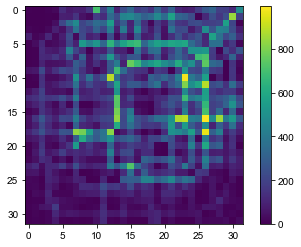

In [3]:
print(dense_tensor_32.shape)
plt.imshow(dense_tensor_32[28])
plt.colorbar()

## Define the model

In [4]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features,omega_0, bias=True,
                 is_first=False): 
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class LRTFR(nn.Module):
    def __init__(self, r_1,r_2,r_3,mid_channel,omega):
        super(LRTFR, self).__init__()
        
        self.U_net = nn.Sequential(SineLayer(1, mid_channel, omega, is_first=True),
                                   SineLayer(mid_channel, mid_channel, omega,is_first=True),
                                   nn.Linear(mid_channel, r_1,omega))
        
        self.V_net = nn.Sequential(SineLayer(1, mid_channel, omega,is_first=True),
                                   SineLayer(mid_channel, mid_channel,omega, is_first=True),
                                   nn.Linear(mid_channel, r_2))
        
        self.W_net = nn.Sequential(SineLayer(1, mid_channel, omega,is_first=True),
                                   SineLayer(mid_channel, mid_channel, omega,is_first=True),
                                   nn.Linear(mid_channel, r_3,omega))

    def forward(self, centre, U_input, V_input, W_input):
        U = self.U_net(U_input)
        V = self.V_net(V_input)
        W = self.W_net(W_input)
        
        centre = centre.permute(1,2,0) 
        centre = centre @ U.t()
        centre = centre.permute(2,1,0) 
        centre = centre @ V.t()
        centre = centre.permute(0,2,1) 
        centre = centre @ W.t()
        return centre


## Run

In [6]:
################### 
# Here are the hyperparameters. 
w_decay = 1  
lr_real = 0.0001
max_iter = 5000
omega = 10 
mid_channel = 512 
###################

dense_tensor = dense_tensor_32.copy()
dim = dense_tensor.shape
missing_rate = 0.8 # Random missing (RM)
np.random.seed(42)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)

X = torch.from_numpy(sparse_tensor).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
[n_1,n_2,n_3] = X.shape

r_1 = min(n_1,n_2,n_3)
r_2 = min(n_1,n_2,n_3)
r_3 = min(n_1,n_2,n_3) 

mask = np.ones(X.shape)
mask[(dense_tensor != 0) & (sparse_tensor == 0)] = 0 
mask = torch.from_numpy(mask).type(dtype).cuda()

### Training

In [7]:
centre = torch.Tensor(r_1,r_2, r_3).type(dtype)
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)
U_input = torch.from_numpy(np.array(range(1,n_1+1))).reshape(n_1,1).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)
W_input = torch.from_numpy(np.array(range(1,n_3+1))).reshape(n_3,1).type(dtype)

model = LRTFR(r_1,r_2,r_3, mid_channel,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr_real, weight_decay=w_decay) 

import time
start = time.time()

loss_record = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input, W_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 90 seconds.


6974.189


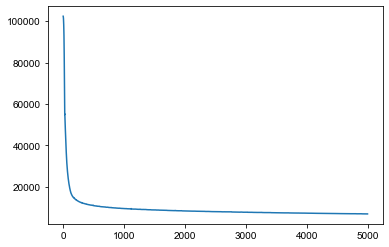

In [8]:
plt.plot(loss_record)
print(loss_record[-1])

This process tasks around 100 seconds in a single GPU device

### Evaluation

WAPE: 0.157401
RMSE: 72.8517


(-0.5, 31.5, 31.5, -0.5)

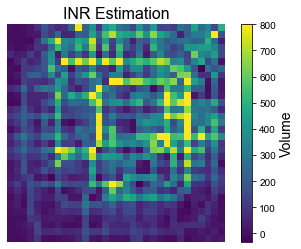

In [9]:
tensor_hat_inr = X_Out.cpu().detach().numpy()
ind = sparse_tensor != 0
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
print('WAPE: {:.6}'.format(compute_wmape(dense_tensor[pos_test], 
                                                    tensor_hat_inr[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], 
                                        tensor_hat_inr[pos_test])))

plt.imshow(tensor_hat_inr[10],vmax=800)
plt.title('INR Estimation',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Volume',fontsize=14)
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

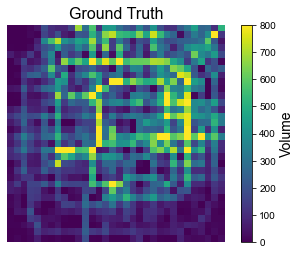

In [10]:
plt.imshow(dense_tensor[10],vmax=800)
plt.title('Ground Truth',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Volume',fontsize=14)
plt.axis('off')

## END